# Gesture Recognition for Hand Cricket Game using ConvNets

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle

%matplotlib inline

In [3]:
np.random.seed(1)

In [4]:
# define the path to the image dataset folder

DATADIR = "D:\Workplace\WorkBench\GitHub\Hand-Cricket-Umpire-DL\dataset\data"
CATEGORIES = ["class_0", "class_1", "class_2", "class_3", "class_4", "class_5", "class_6", "class_7"]

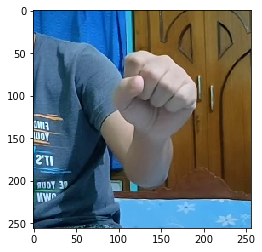

y = 0
shape = (256, 256, 3)


In [5]:
# let's read and see the examples of the pictures

index = 200          # example number m
category = 0       # class y

path = os.path.join(DATADIR, CATEGORIES[category])
img_name = os.listdir(path)[index]

img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_COLOR)
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_array)
plt.show()
print("y = " + str(img_name[5:6]))
print("shape = " + str(img_array.shape))

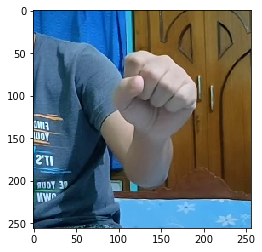

shape = (256, 256, 3)


In [6]:
# resize image acc to the input size to the Neural Network

IMG_SIZE = 256

img_array_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_array_resized)
plt.show()
print("shape = " + str(img_array_resized.shape))

In [7]:
def create_dataset(img_data_root_folder_path, sub_folder_category_name_list, img_size):
    '''
    Reads all the images from the dataset folders and returns a dataset (X, y)
    
    The dataset structure should be:
    A main root folder, inside which there are sub-folders, with their name same as the class name. 
    All these subfolders should contain all the images belonging to that class
    
    inputs:
    img_data_root_folder_path (string): enter the path to the root folder containing all the class folders
    sub_folder_category_name_list (list): list of strings containing the name of the sub-folders
    
    outputs:
    rawData_X: numpy array containing all the images in the form of numpy array
    rawData_y: list contining all the image category labels
    '''
    
    rawData = []
    rawData_X = []
    rawData_y = []
    
    for category in sub_folder_category_name_list:
        path = os.path.join(img_data_root_folder_path, category)  # forms path to all category folders
        class_num = sub_folder_category_name_list.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                img_array_resized = cv2.resize(img_array, (img_size, img_size))

                rawData.append([img_array_resized, class_num])
            except Exception as e:
                print("error reading " + str(img_name))
       
    # shuffle
    np.random.shuffle(rawData)
    
    # split into X and y
    for features, label in rawData:
        rawData_X.append(features)
        rawData_y.append(label)
        
    # convert to required output
    rawData_X = np.array(rawData_X).reshape(-1, img_size, img_size, 3)
    rawData_y = np.array(rawData_y).reshape(1, -1)
    
    return rawData_X, rawData_y

In [8]:
X, y = create_dataset(DATADIR, CATEGORIES, 256)

In [9]:
print ("number of examples = " + str(X.shape[0]))
print ("X shape: " + str(X.shape))
print ("y shape: " + str(y.shape))

number of examples = 2009
X shape: (2009, 256, 256, 3)
y shape: (1, 2009)


In [10]:
print(y)

[[3 5 3 ... 7 0 4]]


In [ ]:
# Example of a picture
index = 1
plt.imshow(X[index])
print ("y = " + str(np.squeeze(y[:, index])))

In [ ]:
# pickle out X and y

# pickle_out = open("X.pickle", "wb")
# pickle.dump(X, pickle_out)
# pickle_out.close()

# pickle_out = open("y.pickle", "wb")
# pickle.dump(y, pickle_out)
# pickle_out.close()

In [ ]:
# pickle in X and y

# pickle_in = open("X.pickle", "rb")
# X = pickle.load(pickle_in)

# pickle_in = open("y.pickle", "rb")
# y = pickle.load(pickle_in)